In [80]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from tqdm import tqdm_notebook, tqdm
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import precision_recall_curve, roc_auc_score, average_precision_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from collections import defaultdict

In [74]:
def f1_score(true_list, pred_list):
    if true_list == [] and pred_list == []:
        raise ValueError((true_list, pred_list)) 
    true = set(true_list)
    pred = set(pred_list)
    cross_size = len(true & pred)
    if cross_size == 0:
        return 0
    p = 1. * cross_size / len(pred)
    r = 1. * cross_size / len(true)
    return 2 * p * r / (p + r)

def get_basket_dict(df):
    d = defaultdict(list)
    for product, order_id in zip(df['product_id'], df['user_id']):
        d[order_id].append(product)
    return d

def in_val(x):
    if x in train_ids:
        return 0
    elif x in val_ids:
        return 1
    else:
        raise ValueError('wrong id')

def score_baskets(pred_baskets, true_baskets):
    scores = [f1_score(products, pred_baskets[order]) for order, products in true_baskets.items()]
    return np.mean(scores)

Вспомогательные функции для подсчета метрик

In [4]:
IDIR = '../input/'

In [5]:
print('Загрузка данных о предыдущих заказах')
priors = pd.read_csv(IDIR + 'order_products__prior.csv', dtype={
            'order_id': np.int32,
            'product_id': np.uint16,
            'add_to_cart_order': np.int16,
            'reordered': np.int8})

print('Загрузка обучающих данных')
train = pd.read_csv(IDIR + 'order_products__train.csv', dtype={
            'order_id': np.int32,
            'product_id': np.uint16,
            'add_to_cart_order': np.int16,
            'reordered': np.int8})

print('Загрузка данных о заказах')
orders = pd.read_csv(IDIR + 'orders.csv', dtype={
        'order_id': np.int32,
        'user_id': np.int32,
        'eval_set': 'category',
        'order_number': np.int16,
        'order_dow': np.int8,
        'order_hour_of_day': np.int8,
        'days_since_prior_order': np.float32})

print('Загрузка данных о продуктах')
products = pd.read_csv(IDIR + 'products.csv', dtype={
        'product_id': np.uint16,
        'order_id': np.int32,
        'aisle_id': np.uint8,
        'department_id': np.uint8},
        usecols=['product_id', 'aisle_id', 'department_id'])

Загрузка данных о предыдущих заказах
Загрузка обучающих данных
Загрузка данных о заказах
Загрузка данных о продуктах


In [6]:
priors.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [7]:
train.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [8]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [9]:
products.head()

,product_id,aisle_id,department_id
0,1,61,19
1,2,104,13
2,3,94,7
3,4,38,1
4,5,5,13


In [10]:
print('priors {}: {}'.format(priors.shape, ', '.join(priors.columns)))
print('orders {}: {}'.format(orders.shape, ', '.join(orders.columns)))
print('train {}: {}'.format(train.shape, ', '.join(train.columns)))

priors (32434489, 4): order_id, product_id, add_to_cart_order, reordered
orders (3421083, 7): order_id, user_id, eval_set, order_number, order_dow, order_hour_of_day, days_since_prior_order
train (1384617, 4): order_id, product_id, add_to_cart_order, reordered


Получим для каждого продукта долю повторных заказов

In [11]:

prods = pd.DataFrame()
prods['orders'] = priors.groupby(priors.product_id).size().astype(np.int32)
prods['reorders'] = priors['reordered'].groupby(priors.product_id).sum().astype(np.float32)
prods['reorder_rate'] = (prods.reorders / prods.orders).astype(np.float32)
products = products.join(prods, on='product_id')
products.set_index('product_id', drop=False, inplace=True)


In [12]:
prods.head()

,orders,reorders,reorder_rate
product_id,,,
1,1852,1136.0,0.613391
2,90,12.0,0.133333
3,277,203.0,0.732852
4,329,147.0,0.446809
5,15,9.0,0.600000


Объединим информацию о предыдущих покупках с информацией о заказах

In [13]:
orders.set_index('order_id', inplace=True, drop=False)
priors = priors.join(orders, on='order_id', rsuffix='_')
priors.drop('order_id_', inplace=True, axis=1)

In [14]:
priors.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,202279,prior,3,5,9,8.0
1,2,28985,2,1,202279,prior,3,5,9,8.0
2,2,9327,3,0,202279,prior,3,5,9,8.0
3,2,45918,4,1,202279,prior,3,5,9,8.0
4,2,30035,5,0,202279,prior,3,5,9,8.0


Получим признаки для каждого пользователя: среднее число дней между покупками, число заказов и среднее число покупок между заказами

In [15]:
usr = pd.DataFrame()
usr['average_days_between_orders'] = orders.groupby('user_id')['days_since_prior_order'].mean().astype(np.float32)
usr['nb_orders'] = orders.groupby('user_id').size().astype(np.int16)

users = pd.DataFrame()
users['total_items'] = priors.groupby('user_id').size().astype(np.int16)
users['all_products'] = priors.groupby('user_id')['product_id'].apply(set)
users['total_distinct_items'] = (users.all_products.map(len)).astype(np.int16)

users = users.join(usr)

In [16]:
users['average_basket'] = (users.total_items / users.nb_orders).astype(np.float32)
print(users.shape)

(206209, 6)


Получим комбинации признаков для пользователей и для продуктов

In [19]:

priors['user_product'] = priors.product_id + priors.user_id * 100000

d = dict()
for row in tqdm(priors.itertuples(), total=len(priors)):
    z = row.user_product
    if z not in d:
        d[z] = (1,
                (row.order_number, row.order_id),
                row.add_to_cart_order)
    else:
        d[z] = (d[z][0] + 1,
                max(d[z][1], (row.order_number, row.order_id)),
                d[z][2] + row.add_to_cart_order)

100%|██████████| 32434489/32434489 [05:00<00:00, 107834.42it/s]


Перегоним признаки в датафрейм

In [20]:
userXproduct = pd.DataFrame.from_dict(d, orient='index')
del d

In [21]:

userXproduct.columns = ['nb_orders', 'last_order_id', 'sum_pos_in_cart']
userXproduct.nb_orders = userXproduct.nb_orders.astype(np.int16)
userXproduct.last_order_id = userXproduct.last_order_id.map(lambda x: x[1]).astype(np.int32)
userXproduct.sum_pos_in_cart = userXproduct.sum_pos_in_cart.astype(np.int16)
print(len(userXproduct))

13307953


In [22]:
train.set_index(['order_id', 'product_id'], inplace=True, drop=False)

Делаем локальную валидацию, нужно разбить на обучающую и тестовую выборки

In [23]:
train_orders = orders[orders.eval_set == 'train']

In [24]:
train_ids, val_ids = train_test_split(orders.query('eval_set == "train"')['user_id'].unique(), 
                                     test_size = 0.3, 
                                     random_state = 1)

Функция для подсчета признаков

In [25]:
def features(selected_orders, labels_given=False):
    print('build candidate list')
    order_list = []
    product_list = []
    labels = []
    i=0
    for row in tqdm(selected_orders.itertuples(), total=len(selected_orders)):
        i+=1
        order_id = row.order_id
        user_id = row.user_id
        user_products = users.all_products[user_id]
        product_list += user_products
        order_list += [order_id] * len(user_products)
        if labels_given:
            labels += [(order_id, product) in train.index for product in user_products]
        
    df = pd.DataFrame({'order_id':order_list, 'product_id':product_list}, dtype=np.int32)
    labels = np.array(labels, dtype=np.int8)
    del order_list
    del product_list
    
    print('Подсчет признаков для пользователей')
    df['user_id'] = df.order_id.map(orders.user_id)
    df['user_total_orders'] = df.user_id.map(users.nb_orders)
    df['user_total_items'] = df.user_id.map(users.total_items)
    df['total_distinct_items'] = df.user_id.map(users.total_distinct_items)
    df['user_average_days_between_orders'] = df.user_id.map(users.average_days_between_orders)
    df['user_average_basket'] =  df.user_id.map(users.average_basket)
    
    print('Подсчет признаков для заказов')
    # df['dow'] = df.order_id.map(orders.order_dow)
    df['order_hour_of_day'] = df.order_id.map(orders.order_hour_of_day)
    df['days_since_prior_order'] = df.order_id.map(orders.days_since_prior_order)
    df['days_since_ratio'] = df.days_since_prior_order / df.user_average_days_between_orders
    
    print('Подсчет признаков для продуктов')
    df['aisle_id'] = df.product_id.map(products.aisle_id)
    df['department_id'] = df.product_id.map(products.department_id)
    df['product_orders'] = df.product_id.map(products.orders).astype(np.int32)
    df['product_reorders'] = df.product_id.map(products.reorders)
    df['product_reorder_rate'] = df.product_id.map(products.reorder_rate)

    print('Подсчет признаков для покупок')
    df['z'] = df.user_id * 100000 + df.product_id
    df.drop(['user_id'], axis=1, inplace=True)
    df['UP_orders'] = df.z.map(userXproduct.nb_orders)
    df['UP_orders_ratio'] = (df.UP_orders / df.user_total_orders).astype(np.float32)
    df['UP_last_order_id'] = df.z.map(userXproduct.last_order_id)
    df['UP_average_pos_in_cart'] = (df.z.map(userXproduct.sum_pos_in_cart) / df.UP_orders).astype(np.float32)
    df['UP_reorder_rate'] = (df.UP_orders / df.user_total_orders).astype(np.float32)
    df['UP_orders_since_last'] = df.user_total_orders - df.UP_last_order_id.map(orders.order_number)
    df['UP_delta_hour_vs_last'] = abs(df.order_hour_of_day - df.UP_last_order_id.map(orders.order_hour_of_day)).map(lambda x: min(x, 24-x)).astype(np.int8)
    #df['UP_same_dow_as_last_order'] = df.UP_last_order_id.map(orders.order_dow) == \
    #                                              df.order_id.map(orders.order_dow)

    df.drop(['UP_last_order_id', 'z'], axis=1, inplace=True)
    print(df.dtypes)
    print(df.memory_usage())
    return (df, labels)

Получим признаки для обучающей выборки и обучим модель

In [43]:
df_train, labels = features(orders[orders.user_id.isin(train_ids)], labels_given=True)

f_to_use = ['user_total_orders', 'user_total_items', 'total_distinct_items',
       'user_average_days_between_orders', 'user_average_basket',
       'order_hour_of_day', 'days_since_prior_order', 'days_since_ratio',
       'aisle_id', 'department_id', 'product_orders', 'product_reorders',
       'product_reorder_rate', 'UP_orders', 'UP_orders_ratio',
       'UP_average_pos_in_cart', 'UP_reorder_rate', 'UP_orders_since_last',
       'UP_delta_hour_vs_last'] 


# Преобразование датафрейма в формат LGBM
d_train = lgb.Dataset(df_train[f_to_use],
                      label=labels,
                      categorical_feature=['aisle_id', 'department_id'])  # , 'order_hour_of_day', 'dow'
# del df_train

build candidate list


100%|██████████| 1528346/1528346 [33:36<00:00, 757.95it/s]


Подсчет признаков для пользователей
Подсчет признаков для заказов
Подсчет признаков для продуктов
Подсчет признаков для покупок
order_id                              int32
product_id                            int32
user_total_orders                     int16
user_total_items                      int16
total_distinct_items                  int16
user_average_days_between_orders    float32
user_average_basket                 float32
order_hour_of_day                      int8
days_since_prior_order              float32
days_since_ratio                    float32
aisle_id                              uint8
department_id                         uint8
product_orders                        int32
product_reorders                    float32
product_reorder_rate                float32
UP_orders                             int16
UP_orders_ratio                     float32
UP_average_pos_in_cart              float32
UP_reorder_rate                     float32
UP_orders_since_last                

In [27]:


params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': {'binary_logloss'},
    'num_leaves': 96,
    'max_depth': 10,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.95,
    'bagging_freq': 5
}
ROUNDS = 100

# Собственно обучение
bst = lgb.train(params, d_train, ROUNDS)
#del d_train

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


In [44]:
import pickle
with open('df_train.pkl', 'wb') as f:
    pickle.dump(df_train, f, protocol=4)

In [49]:
del train

Построение валидационной выборки

In [28]:
df_test, test_labels = features(orders[orders.user_id.isin(val_ids)], labels_given=True)

  0%|          | 0/650240 [00:00<?, ?it/s]

build candidate list


100%|██████████| 650240/650240 [14:24<00:00, 751.75it/s]


Подсчет признаков для пользователей
Подсчет признаков для заказов
Подсчет признаков для продуктов
Подсчет признаков для покупок
order_id                              int32
product_id                            int32
user_total_orders                     int16
user_total_items                      int16
total_distinct_items                  int16
user_average_days_between_orders    float32
user_average_basket                 float32
order_hour_of_day                      int8
days_since_prior_order              float32
days_since_ratio                    float32
aisle_id                              uint8
department_id                         uint8
product_orders                        int32
product_reorders                    float32
product_reorder_rate                float32
UP_orders                             int16
UP_orders_ratio                     float32
UP_average_pos_in_cart              float32
UP_reorder_rate                     float32
UP_orders_since_last                

In [42]:
test_labels = _

In [27]:
import pickle
with open('df_test.pkl', 'wb') as f:
    pickle.dump(df_test, f, protocol=4)

In [29]:
preds = bst.predict(df_test[f_to_use])

df_test['pred'] = preds

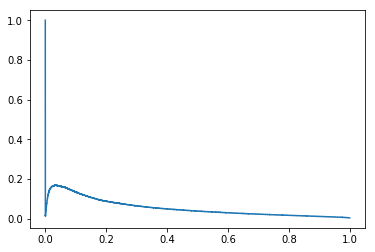

In [33]:
precision, recall, thresholds = precision_recall_curve(test_labels, df_test['pred'])
plt.plot(recall, precision)

Логистическая регрессия

In [46]:
clf = LogisticRegression()

In [50]:
features_linear = f_to_use.copy()
features_linear.remove('aisle_id')
features_linear.remove('department_id')

In [54]:
scaler = StandardScaler()
X_train = scaler.fit_transform(df_train[features_linear].fillna(0))

In [55]:
clf.fit(X_train, labels)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [56]:
X_test = scaler.transform(df_test[features_linear].fillna(0))

In [57]:
%%time
test_preds = clf.predict_proba(X_test)

CPU times: user 8.16 s, sys: 1.46 s, total: 9.62 s
Wall time: 4.61 s


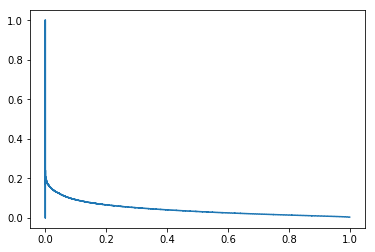

In [59]:
precision, recall, thresholds = precision_recall_curve(test_labels, test_preds[:, 1])
plt.plot(recall, precision)

In [61]:
param_grid = {'C': np.logspace(-3, 3, 7)}
estimator = LogisticRegression()
gs = GridSearchCV(estimator, param_grid, cv=3, verbose=3, scoring='average_precision')

In [62]:
gs.fit(X_train, labels)

KeyboardInterrupt: 

Пришлось остановить, вот промежуточные результаты:

In [ ]:
Fitting 3 folds for each of 7 candidates, totalling 21 fits
[CV] C=0.001 .........................................................
[CV] ............... C=0.001, score=0.04298339813563154, total=16.1min
[CV] C=0.001 .........................................................
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 17.2min remaining:    0.0s
[CV] ............... C=0.001, score=0.04263224375217381, total=16.0min
[CV] C=0.001 .........................................................
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 34.3min remaining:    0.0s
[CV] ............... C=0.001, score=0.04259252228336225, total=16.1min
[CV] C=0.01 ..........................................................
[CV] ................ C=0.01, score=0.04343548475918307, total=17.0min
[CV] C=0.01 ..........................................................
[CV] ................ C=0.01, score=0.04308460051966365, total=23.7min
[CV] C=0.01 ..........................................................
[CV] ............... C=0.01, score=0.043044242330857574, total=18.8min
[CV] C=0.1 ...........................................................

In [64]:
param_grid = {'C': np.logspace(-1, 3, 5)}
estimator = LogisticRegression()
gs = GridSearchCV(estimator, param_grid, cv=3, verbose=3, scoring='average_precision')
gs.fit(X_train, labels)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] C=0.1 ...........................................................
[CV] ................ C=0.1, score=0.043487330711054845, total=22.2min
[CV] C=0.1 ...........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 23.3min remaining:    0.0s


[CV] ................ C=0.1, score=0.043135326344098376, total=19.6min
[CV] C=0.1 ...........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 44.0min remaining:    0.0s


[CV] ................. C=0.1, score=0.04309616100995022, total=22.9min
[CV] C=1.0 ...........................................................
[CV] .................. C=1.0, score=0.0434927680060392, total=22.6min
[CV] C=1.0 ...........................................................
[CV] ................. C=1.0, score=0.04314131555900182, total=21.5min
[CV] C=1.0 ...........................................................
[CV] ................ C=1.0, score=0.043101442411653895, total=21.5min
[CV] C=10.0 ..........................................................
[CV] ................ C=10.0, score=0.04349328403517681, total=20.8min
[CV] C=10.0 ..........................................................
[CV] ................ C=10.0, score=0.04314184379663601, total=21.0min
[CV] C=10.0 ..........................................................
[CV] ................ C=10.0, score=0.04310196118334664, total=21.0min
[CV] C=100.0 .........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed: 340.2min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': array([  1.00000e-01,   1.00000e+00,   1.00000e+01,   1.00000e+02,
         1.00000e+03])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='average_precision', verbose=3)

In [63]:
with open('train_labels.pkl', 'wb') as f:
    pickle.dump(labels, f)

In [65]:
with open('gs_logreg.pkl', 'wb') as f:
    pickle.dump(gs, f)

In [69]:
logreg_test_preds = gs.best_estimator_.predict_proba(X_test)

In [70]:
roc_auc_score(test_labels, logreg_test_preds[:, 1]), average_precision_score(test_labels, logreg_test_preds[:, 1])

(0.87848424867536667, 0.043260752109679307)

In [73]:
with open('features_train_new.pkl', 'wb') as f:
    pickle.dump((X_train, labels), f, protocol=4)

In [75]:
train_ids, val_ids = train_test_split(orders.query('eval_set == "train"')['user_id'].unique(), test_size = 0.3, random_state = 1)
train_ids, val_ids = set(train_ids), set(val_ids)

In [78]:
temp = train.merge(orders[['order_id', 'user_id']], how = 'inner', on = ['order_id'])
temp['is_val'] = temp['user_id'].apply(in_val)

train_baskets = get_basket_dict(temp.query('is_val == 0'))
val_baskets = get_basket_dict(temp.query('is_val == 1'))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 'order_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  """Entry point for launching an IPython kernel.


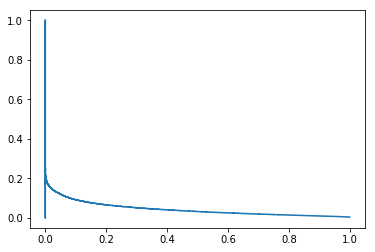

In [79]:
precision, recall, thresholds = precision_recall_curve(test_labels, logreg_test_preds[:, 1])
plt.plot(recall, precision)

In [88]:
t = 0.1

In [89]:
print('f1={}'.format(f1_score(test_labels, logreg_test_preds[:, 1] > t)))

f1=0.304
